In [3]:
import torch
from scripts.fit import fit

In [1]:
from scripts.prompt import gen_prompt_head

In [10]:
system_name = 'pendulum'
system_description = 'Pendulum is a massive object attached to a rope and making periodic motion in a gravity field.'
data_description = 'The states of pendulum are described by angle and angular velocity, so each states tensor x has shape (nx2), where n is the number of observations. The forward method should predict the state of the pendulum after some time from the given state, so the expected output\'s y shape is (nx2).'

t = torch.linspace(0, 10, 1000)
x = torch.stack((torch.sin(2 * t), 2 * torch.cos(2 * t)), dim=1)
y = x[1:]
x = x[:-1]
t = t[:-1]
example_data = x[:5], y[:5]

print(gen_prompt_head(system_name, system_description, data_description, example_data))

Write a torch class describing pendulum.
 Pendulum is a massive object attached to a rope and making periodic motion in a gravity field..Return ONLY the code of the class.
The class initialises learnable parameters, such as length of a pendulum of Jung modulus of material.It also implements forward method which predicts states pass some fixed time given the current state.
The states of pendulum are described by angle and angular velocity, so each states tensor x has shape (nx2), where n is the number of observations. The forward method should predict the state of the pendulum after some time from the given state, so the expected output's y shape is (nx2).
Here is an example of input for the forward method: tensor([[0.0000, 2.0000],
        [0.0200, 1.9996],
        [0.0400, 1.9984],
        [0.0600, 1.9964],
        [0.0800, 1.9936]]), and expected output: tensor([[0.0200, 1.9996],
        [0.0400, 1.9984],
        [0.0600, 1.9964],
        [0.0800, 1.9936],
        [0.0999, 1.9900]]).

In [53]:
model_definition = """class Physics(nn.Module):
    def __init__(self):
        super(Physics, self).__init__()
        
        self.omega = nn.Parameter(torch.randn(1), requires_grad=True)
        self.dt = nn.Parameter(torch.randn(1), requires_grad=True)
        
    def forward(self, states):
        dphi = self.omega * self.dt
        x = torch.cos(dphi) * states[..., 0] + torch.sin(dphi) / self.omega * states[..., 1]
        v = -torch.sin(dphi) * self.omega * states[..., 0] + torch.cos(dphi) * states[..., 1]
        
        return torch.stack((x, v), dim=-1)"""

model, loss = fit(model_definition, x, y, optim_defaults={'lr': 1e-2})
loss

100%|██████████| 100/100 [00:01<00:00, 50.62it/s] 


2.0795484445557122e-08

In [54]:
model.dt

Parameter containing:
tensor([0.0101], requires_grad=True)

In [55]:
model.omega

Parameter containing:
tensor([-1.9841], requires_grad=True)

In [11]:
import matplotlib.pyplot as plt

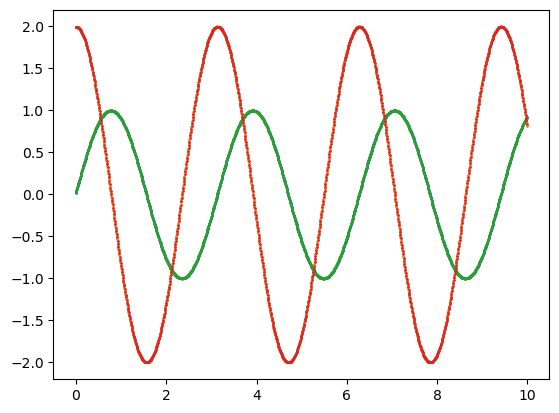

In [18]:
# plt.scatter(t, x[:, 0], s=1)
# plt.scatter(t, x[:, 1], s=1)

plt.scatter(t, y[:, 0], s=1)
plt.scatter(t, y[:, 1], s=1)

plt.scatter(t, model(x)[:, 0].detach(), s=1)
plt.scatter(t, model(x)[:, 1].detach(), s=1)

In [6]:
import torch.nn as nn
exec(model_definition)

In [8]:
model = Physics()

In [12]:
dphi = model.dt * model.omega
multiplier = torch.tensor([[torch.cos(dphi), -torch.sin(dphi)], [torch.sin(dphi) / model.omega, torch.cos(dphi) / model.omega]])
multiplier

tensor([[ 0.9988,  0.0491],
        [ 0.1155, -2.3495]])

In [ ]:
# x(t) = sin(omega t)
# v(t) = omega * cos(omega t)

# x(t + dt) = sin(omega t)cos(omega dt) + sin(omega dt) * cos(omega dt) = cos(omega dt) * x(t) + sin(omega dt) / omega * v(t)
# v(t + dt) = cos(omega t)cos(omega dt) - sin(omega t)sin(omega dt) = 